In [1]:
import pandas as pd
import numpy as np
import spacy
import json
import re

import seaborn as sns
import matplotlib.pyplot as plt

from guess_language import guess_language
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [2]:
DATA_PATH = 'preprocessed-data/'

In [3]:
posts = pd.read_csv(f'{DATA_PATH}teams_2_3_8_10_posts.csv', sep=';', index_col=0)
print(posts.info())
posts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9802 entries, 0 to 9801
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    9802 non-null   object 
 1   post_url       117 non-null    object 
 2   post           9802 non-null   object 
 3   reactions_cnt  9653 non-null   object 
 4   comments_cnt   9467 non-null   float64
 5   reposts_cnt    9356 non-null   float64
dtypes: float64(2), object(4)
memory usage: 536.0+ KB
None


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt
0,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Кстати говоря. Теперь подкаст Миражи доступен ...,1,0.0,0.0
1,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,I’m #hiring. Know anyone who might be interested?,1,0.0,0.0
2,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Хэй честной народ! Ищу векторного иллюстратора...,6,0.0,0.0
3,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Новый пост подкаста ""Миражи"" на всех платформа...",1,0.0,0.0
4,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Подкаст Миражи, Эпизод 13Ошибка невозвратных з...",2,0.0,0.0


# Категоризация текстов по языку

Так как при парсинге в выборку попадали тексты на разных языках, произведем категоризацию по ним, используя библиотеку `guess_language`

In [4]:
posts['language'] = posts['post'].apply(guess_language)
posts.sample(10)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language
5846,https://www.linkedin.com/in/andreykhalov/recen...,NaN,Another mind-blowing AI solution that I discov...,207,24.0,3.0,en
3927,https://www.linkedin.com/in/serhii-verzhbytsky...,NaN,I know that look! I'm curious how this will tu...,3,0.0,0.0,en
8855,https://www.linkedin.com/in/elminaliev/recent-...,NaN,New Dyson bladeless jet engine selected for al...,0,0.0,0.0,en
7611,https://www.linkedin.com/in/viktor-zhitomirski...,NaN,"Hi everyone ✌️Check out our new project, AiBoo...",11,0.0,1.0,en
73,https://www.linkedin.com/in/anton-kartunov-974...,NaN,How does a mobile application help a business ...,1,0.0,0.0,en
5349,https://www.linkedin.com/in/ikhokhryakov/recen...,NaN,Some thoughts to consider...,1,0.0,0.0,en
7773,https://www.linkedin.com/in/raiars/recent-acti...,NaN,Created a website about traveling to Mars🚀Crea...,3,0.0,0.0,en
587,https://www.linkedin.com/in/vladimir-yelizarof...,NaN,#автоматизациябизнеса #перевозки,3,2.0,0.0,uk
1530,https://www.linkedin.com/in/kris-kostina/recen...,NaN,Согласны? 🤔 Относится ли вообще эта мысль к ай...,11,20.0,0.0,ru
9046,https://www.linkedin.com/in/dair-mustakhimov-8...,NaN,Today I published an article on Habr about how...,38,4.0,4.0,en


По десяти случайным строкам видно, что есть категория UNKNOWN и какие-то языки кроме английского и русского. Посмотрим внимательнее

In [5]:
posts['language'].value_counts()

en         6056
ru         2287
UNKNOWN     386
uk          226
bg          181
fr           77
de           47
ca           42
af           38
az           36
mk           35
it           35
nl           33
da           32
ro           30
hy           29
la           29
es           21
tl           17
nb           17
eo           15
sr           13
sv           13
ar           11
pt           11
id           10
fi            7
ha            7
nso           6
haw           4
he            4
sl            4
kk            4
sq            3
tr            3
ss            3
cy            3
uz            3
is            3
hr            3
et            2
ceb           2
hu            2
tn            2
sk            2
vi            1
so            1
ka            1
ve            1
tlh           1
st            1
ky            1
lt            1
Name: language, dtype: int64

Большинство текстов написаны на  русском и английском языках. Визуально посмотрим, на тексты иных языков 'uk', 'bg', 'fr' и категорию `unknown`. Эти категории мамые популярные:

In [6]:
posts.query('language == "UNKNOWN"')[['post', 'language']].sample(10)

,post,language
8217,#humor,UNKNOWN
8712,https://t.co/0NXqsMK256,UNKNOWN
569,#автоматизация,UNKNOWN
8992,С добрым утром),UNKNOWN
3891,🔥,UNKNOWN
9001,IDA: What's new in 7.3,UNKNOWN
267,#рекомендую,UNKNOWN
5272,❤️,UNKNOWN
3489,Good insight!,UNKNOWN
5012,#it #humor,UNKNOWN


Похоже, это очень короткие тексты, которые нам особо не пригодятся. Исключим из выборки

In [7]:
posts.query('language == "uk"')[['post', 'language']].sample(10)

,post,language
5048,Favbet та Міністерство молоді та спорту Україн...,uk
4376,"Вітаємо всіх веб-розробників, дизайнерів! Я вд...",uk
4683,До Дня захисників та захисниць ми відкриваємо ...,uk
8757,Жизненно :) Так я перестал пользоваться FB,uk
4650,(English below)Завжди приємно на vue.js щось д...,uk
5599,"Вітаю, дорогі українці!В цей непростий для наш...",uk
2122,Як знайти роботу в кризу та отримати від цього...,uk
5046,25.06.2023 SAVE THE DATEФутболісти та геймери ...,uk
2121,Які виклики зараз стоять перед продакт менедже...,uk
5063,Разом з Favbet Foundation ми створювали «Клуб ...,uk


Украинский язык (логично :-)). Для того, чтобы не подгружать множество языковых моделей, думаю, что целесообразно исключить его из общей выборки. Сосредоточимся на наиболее популярных языках 'ru' и 'en'. Посмотрим 'bg':

In [8]:
posts.query('language == "bg"')[['post', 'language']].sample(10)

,post,language
2311,"город Бишкек, ищем ментора в Zeon IT Hub#вакан...",bg
823,"Выкладываю решение с хакатона ""Лидер цифровой ...",bg
8488,Это бич ленты linkedin,bg
9159,Вот и выдали мне сертификат :)#skillbox #unity...,bg
754,Находки в сети за апрель,bg
4700,🔔 28 июня в 17:00 (по МСК) приглашаю вас на ве...,bg
777,Написал про работу с HBase в Erlang'е использу...,bg
769,Находки в сети за август,bg
6259,С 11 по 13 августа в г.Калуга состоится IX Фор...,bg
631,За последние 1.5 года армянские стартапы привл...,bg


Большинство текстов с такой меткой написаны на русском. Думаю, что стоит поменять метку языка 'bg' на 'ru'

In [9]:
posts.query('language == "fr"')[['post', 'language']].sample(10)

,post,language
9755,CV ML Engineer#computervision #ml #engineer,fr
13,Yeah! #gopractice #productmanagement #datadriven,fr
9193,Unity 2D Game Development Projects – Rogue Frog,fr
8124,Check out our latest Newsletter post ⤵,fr
6715,Il a créé un filtre en réalité augmentée qui f...,fr
6733,#javascript #levelhunt,fr
8020,Wrote a post on how to check your DV-LOTTERY 2...,fr
5316,Do you need investment? Leave a request.,fr
8349,"Коли QA робить регрессію одразу за 3 спринта:""...",fr
752,June Picks https://lnkd.in/fuAsDRr,fr


Большой разброс по фактическим языкам. Думаю, что эту категорию не стоит включать в выборку. Подкорректируем метки функцией и посмотрим, что получилось:

In [10]:
def lang_correction(text):
    if text == 'bg':
        return 'ru'
    elif text == 'UNKNOWN' or text == 'ru' or text == 'en':
        return text
    else:
        return 'UNKNOWN'

In [11]:
posts['language'] = posts['language'].apply(lang_correction)
posts['language'].value_counts()

en         6056
ru         2468
UNKNOWN    1278
Name: language, dtype: int64

Метка UNKNOWN позволит нам легко исключить ненужные нам для анализа тексты. А что с длиной текстов. Построим распределение:

In [12]:
def post_len(text):
    return len(text)

posts['post_len'] = posts['post'].apply(post_len)

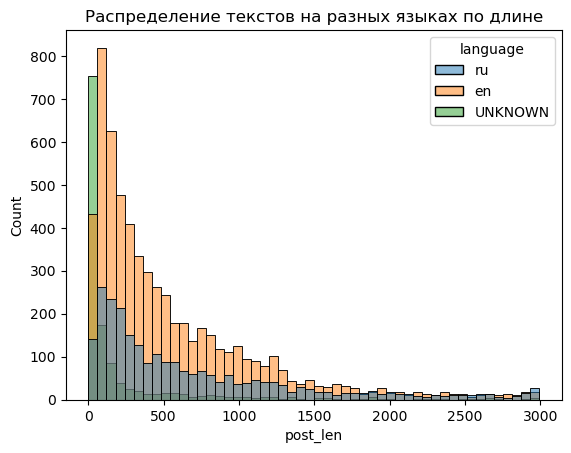

In [13]:
sns.histplot(posts, x='post_len',
                    hue="language").set_title('Распределение текстов на разных языках по длине')
plt.show()

Большинство текстов на русском и английском языках длиной меньше 500 символов. Также подтверждается гипотеза, что метка UNKNOWN в значимой степени связана с длиной текста (гистограмма резче остальных показывает спад количества с увеличением длины).

In [14]:
posts_en = posts.query('language == "en"')
posts_en.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len
4737,https://www.linkedin.com/in/dyakov-ivan/recent...,NaN,Virtual Medicine: Breaking Barriers with Telem...,1,0.0,0.0,en,2710
2417,https://www.linkedin.com/in/vpilip/recent-acti...,NaN,Your B2B SaaS product might have a self-servic...,6,0.0,1.0,en,725
5124,https://www.linkedin.com/in/liliya-khatskevich...,NaN,Time management is a critical factor in achiev...,6,0.0,0.0,en,1035
1881,https://www.linkedin.com/in/anton-cucer/recent...,NaN,TOP 5 films that will be useful to the project...,1,0.0,0.0,en,1422
1935,https://www.linkedin.com/in/levonabelyan/recen...,NaN,Here are some #sneakpeek of our game art!More ...,1,0.0,0.0,en,95


In [15]:
posts_ru = posts.query('language == "ru"')
posts_ru.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len
1367,https://www.linkedin.com/in/ko22009/recent-act...,NaN,FastStone Image идеальная программа для просмо...,0,0.0,0.0,ru,116
236,https://www.linkedin.com/in/olgaperun/recent-a...,NaN,#кейсынаконсультацииСпасибо моей аудитории за ...,0,0.0,0.0,ru,794
9152,https://www.linkedin.com/in/0juba,NaN,Участвуем в ежегодном рейтинге лучших работода...,0,0.0,0.0,ru,281
184,https://www.linkedin.com/in/mikhailsolovyev/re...,NaN,Первый раз о цифровом суверенитете я услышал о...,11,3.0,1.0,ru,968
1045,https://www.linkedin.com/in/%D1%81%D1%82%D0%B5...,NaN,Недавно с Eugene Vasil'ev провели мини лекцию ...,30,2.0,1.0,ru,259


# Подготовка текстов

Скачаем и загрузим модели (библиотеку spacy предварительно установили)

In [16]:
! python -m spacy download ru_core_news_sm >> None
! python -m spacy download en_core_web_sm >> None

In [17]:
model_en = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
model_ru = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Сохраним посты на английском и русском языках, как списки

In [18]:
posts_ru_list = list(posts_ru['post'])
posts_en_list = list(posts_en['post'])

Лемматизируем посты и сохраним результат в файлы

In [19]:
res_ru = []
for doc in model_ru.pipe(posts_ru_list, disable=["tagger", "parser"]):
    res_ru.append([token.lemma_ for token in doc])
    
with open("lemmas_ru.json", "w") as fid:
    json.dump({"lemmas_ru": res_ru}, fid)

In [20]:
res_en = []
for doc in model_en.pipe(posts_en_list, disable=["tagger", "parser"]):
    res_en.append([token.lemma_ for token in doc])
    
with open("lemmas_en.json", "w") as fid:
    json.dump({"lemmas_en": res_en}, fid)

C:\Dev\Jupyter\dist\pyenv3.10-win64\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Проконтролируем, что получилось.

In [21]:
", ".join(res_ru[np.random.randint(len(res_ru))])

'celebrating, my, work, anniversary, ., напомнить, мир, ,, что, уже, год, работать, в, tengizchevroil, ., принимать, поздравление, ,, гордый, себя, !'

In [22]:
", ".join(res_en[np.random.randint(len(res_en))])

'if, you, wish, a, website, in, this, style, ,, contact, us!, 🌜, 🌗, webdevelopment,  , and, design, consulting, at, your, services, ., #, website, #, style, #, design, #, art#digitalart, #, artdesign, #, artificialintelligence'

Остаётся констатировать, что лемматизация прошла успешно. Почистим тексты:

In [23]:
word_pattern_ru = re.compile("^[а-я]*$")
word_pattern_en = re.compile("^[a-z]*$")

In [24]:
def remove_symbols_ru(doc):
    return [token for token in doc if word_pattern_ru.match(token)]

def remove_symbols_en(doc):
    return [token for token in doc if word_pattern_en.match(token)]

In [25]:
corpus_ru = list(map(remove_symbols_ru, res_ru))
corpus_en = list(map(remove_symbols_en, res_en))

In [26]:
", ".join(corpus_ru[np.random.randint(len(corpus_ru))])

'сколько, бы, книга, или, сколько, бы, курс, не, проходи, все, равный, нужный, навык, и, талант, продажа, сегодня, я, делать, листовка, и, визитка, и, отправить, его, в, типография, учитывать, что, у, меня, цена, высоко, на, печатный, дизайн, равный, у, меня, его, заказать, мой, маленький, достижение, сейчас, подписывать, договор, на, маленький, проект, где, час, мой, работа, оцениваться, в, я, не, мочь, поверить, что, это, весь, происходить, со, мной, сейчас, согласиться, у, меня, не, такой, крутой, портфолио, как, у, других, дизайнер, и, мой, английский, оставлять, желать, хороший, но, вот, мой, навык, самопрезентации, и, то, что, я, уметь, продавать, не, продоваемое, это, мой, талант'

In [27]:
", ".join(corpus_en[np.random.randint(len(corpus_en))])

'a, new, case, describes, the, creation, of, a, website, and, an, admin, panel, for, a, hoteldime, project'

Отличный результат. Удалим стоп-слова и будет идеально.

# Векторизация текстов

 Подгружаем и формируем список стоп-слов

In [28]:
stop_words_ru = stopwords.words('russian')
stop_words_en = stopwords.words('english')

# сформируем единый список для обоих языков - это не помешает работе векторайзера
stop_words = stop_words_ru + stop_words_en

Объединим отдельные слова обратно в тексты и проконтролируем результат

In [29]:
docs_en = [" ".join(tokens) for tokens in corpus_en]
docs_en[:3]

['i hiring know anyone who might be interested',
 'hello everyone i ecstatic to announce my new role as ceo of metakratos studio a seasoned it firm known for delivering advanced software solutions across various industries such as finance it blockchain industrial automatization security edtech and advertising with years of experience in empowering businesses of all sizes to achieve rapid growth and effortless scaling metakratos studio has built a reputation for excellence and innovation i honored to be leading this incredible team and eager to continue the company legacy of pushing the boundaries of technology as we embark on this journey together i look forward to tackling new challenges seizing opportunities and fostering a culture of collaboration and creativity within our team i committed to ensuring that metakratos studio remains at the forefront of innovation and continues to make a lasting impact on the industries we serve i invite you to follow the metakratos studio community o

In [30]:
docs_ru = [" ".join(tokens) for tokens in corpus_ru]
docs_ru[:3]

['кстати говорить теперь подкаст миражи доступный в соцсеть вконтакте наконец разобраться как туда прикрутить мираж',
 'хэй честной народ искать векторный иллюстратор на проект с возможный длительный сотрудничество по итог можно уровень иллюстрация не плохой чем в пример ты уметь так рисовать напиши мне в личка иллюстрация проект',
 'новый пост подкаст мираж на весь платформа в аудио инстаграм а патреоне психология психологиячеловека психологияжизни психологияличности личностныйрост подкаст подкастмиражи маркетинг осознанность мысль мысливслух установка влияние подсознаниеиспользованные звук музыка и картинка аудиоцитата из фильм формула любовь марка']

Успешно. Векторизируем тексты

In [31]:
# создаём "векторизатор" :-)
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

Векторизируем тексты на двух языках, создадим список векторизированных слов и проконтролируем результат

In [32]:
x_ru = tfidf.fit_transform(docs_ru)
id2word_ru = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

x_ru.shape

(2468, 1929)

In [33]:
x_en = tfidf.fit_transform(docs_en)
id2word_en = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

x_en.shape

(6056, 3648)

# LDA

Сформируем топ-100 тем

In [34]:
n_topics = 100

In [35]:
lda_ru = LatentDirichletAllocation(n_components=n_topics, random_state=10723)
topics_ru = lda_ru.fit_transform(x_ru)
topics_ru.shape

(2468, 100)

In [36]:
lda_en = LatentDirichletAllocation(n_components=n_topics, random_state=10723)
topics_en = lda_en.fit_transform(x_en)
topics_en.shape

(6056, 100)

# Формирование датафреймов

Сформируем общие датафреймы для последующего анализа.

In [37]:
# выбираем наиболее вероятную тему для каждого поста
df_topics_ru = pd.DataFrame(topics_ru, index=posts_ru.index).transpose().idxmax()

# мерджим с общей таблицей
df_posts_ru = posts_ru.merge(pd.Series(df_topics_ru, name='topic'),
               left_index=True,
               right_index=True).reset_index(drop=True)

df_posts_ru.head()

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
0,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Кстати говоря. Теперь подкаст Миражи доступен ...,1,0.0,0.0,ru,155,39
1,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Хэй честной народ! Ищу векторного иллюстратора...,6,0.0,0.0,ru,486,39
2,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Новый пост подкаста ""Миражи"" на всех платформа...",1,0.0,0.0,ru,614,38
3,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Подкаст Миражи, Эпизод 13Ошибка невозвратных з...",2,0.0,0.0,ru,143,37
4,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Редкий случай, когда считаю правильным распрос...",0,0.0,0.0,ru,326,39


С русским языком порядок, теперь английский

In [38]:
# выбираем наиболее вероятную тему для каждого поста
df_topics_en = pd.DataFrame(topics_en, index=posts_en.index).transpose().idxmax()

# мерджим с общей таблицей
df_posts_en = posts_en.merge(pd.Series(df_topics_en, name='topic'),
               left_index=True,
               right_index=True).reset_index(drop=True)

df_posts_en.head()

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
0,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,I’m #hiring. Know anyone who might be interested?,1,0.0,0.0,en,49,11
1,https://www.linkedin.com/in/ikotow/recent-acti...,NaN,Hello Everyone! I'm ecstatic to announce my ne...,21,1.0,1.0,en,1356,56
2,https://www.linkedin.com/in/groshev-andrew/rec...,NaN,Elon Musk (@elonmusk) твитнул(а): Sending this...,0,0.0,0.0,en,91,65
3,https://www.linkedin.com/in/groshev-andrew/rec...,NaN,Wow ! I loved this videohttps://zuzus.tech,0,0.0,0.0,en,42,6
4,https://www.linkedin.com/in/spasatos/recent-ac...,NaN,"I teach ""Data Visualization"" at the Higher Sch...",0,0.0,0.0,en,210,47


Успешно. Поработаем немного с пропусками в данных

In [39]:
print(df_posts_en.info())
print('\n')
df_posts_ru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    6056 non-null   object 
 1   post_url       49 non-null     object 
 2   post           6056 non-null   object 
 3   reactions_cnt  5989 non-null   object 
 4   comments_cnt   5909 non-null   float64
 5   reposts_cnt    5872 non-null   float64
 6   language       6056 non-null   object 
 7   post_len       6056 non-null   int64  
 8   topic          6056 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 425.9+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    2468 non-null   object 
 1   post_url       42 non-null     object 
 2   post           2468 non-null   object 
 3   reaction

видно, что есть пропуски. Заполним их учитывая логику парсинга. Пропуски в количестве реакций и комментариев означают их отсутствие - заполним нулями. Ссылки на посты тоже не всем удалось собрать. Тоже можно заполнить нулём со смыслом - "отсутствует"

In [40]:
df_posts_ru = df_posts_ru.fillna(0)
df_posts_en = df_posts_en.fillna(0)

In [41]:
print(df_posts_en.info())
print('\n')
df_posts_ru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6056 entries, 0 to 6055
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    6056 non-null   object 
 1   post_url       6056 non-null   object 
 2   post           6056 non-null   object 
 3   reactions_cnt  6056 non-null   object 
 4   comments_cnt   6056 non-null   float64
 5   reposts_cnt    6056 non-null   float64
 6   language       6056 non-null   object 
 7   post_len       6056 non-null   int64  
 8   topic          6056 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 425.9+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    2468 non-null   object 
 1   post_url       2468 non-null   object 
 2   post           2468 non-null   object 
 3   reaction

Замена прошла успешно. Посмотрим на результат визуально.

In [42]:
display(df_posts_en.sample(5))
print('\n')
df_posts_ru.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
3801,https://www.linkedin.com/in/vdrogan/recent-act...,0,"This project, for which we received an excelle...",10,0.0,1.0,en,769,56
4469,https://www.linkedin.com/in/anna-pronina/recen...,0,"When it comes to data storage, processing, and...",21,0.0,0.0,en,2142,7
5374,https://www.linkedin.com/in/rybitva/recent-act...,0,UpWork has added a new feature to share feedba...,3,0.0,1.0,en,65,47
2227,https://www.linkedin.com/in/irina-boldyrieva/r...,0,🎯 Let’s play a quick Bingo game: Overwhelmed w...,2,0.0,0.0,en,700,7
5420,https://www.linkedin.com/in/anastasiya-burdeyn...,0,I'm attending virtual.drupa. Let's boost the p...,2,0.0,0.0,en,103,61


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
346,https://www.linkedin.com/in/pavelandronov/rece...,0,13 лет назад программист Ласло Хейниц купил дв...,3,0.0,0.0,ru,167,57
1107,https://www.linkedin.com/in/daryn-arkadan-a825...,0,История VebTech начиналась с 3 человек. Теперь...,41,1.0,5.0,ru,2700,56
1375,https://www.linkedin.com/in/%D0%B5%D1%80%D0%BB...,0,Продай мне ручку.⠀Когда я интенсивно строил от...,22,29.0,0.0,ru,2486,56
1815,https://www.linkedin.com/in/sspetrov/recent-ac...,0,Notion в последнее время стал быстро двигаться...,2,0.0,0.0,ru,57,10
560,https://www.linkedin.com/in/drazd/recent-activ...,0,"Мир RPA куда интереснее и глубже, чем может по...",10,1.0,0.0,ru,1203,56


Визуально всё в порядке.

Выделим топ-10 популярных тем для русскоязычных и англоязычных постов и построим иллюстрирующие популярность графики

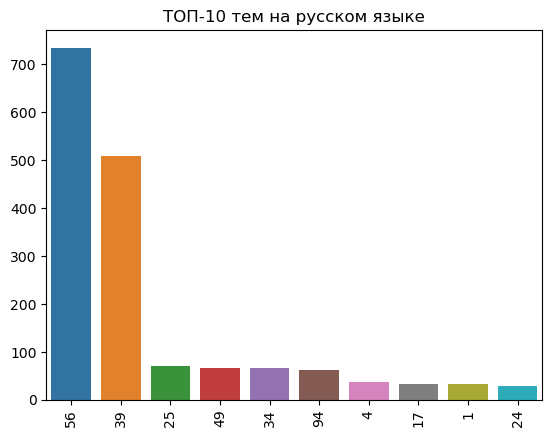

In [43]:
top10topic_ru = df_posts_ru['topic'].value_counts().head(10)
sns.barplot(x=top10topic_ru.index, y=top10topic_ru.values, order=top10topic_ru.index).set_title('ТОП-10 тем на русском языке')
plt.xticks(rotation=90)
plt.show()

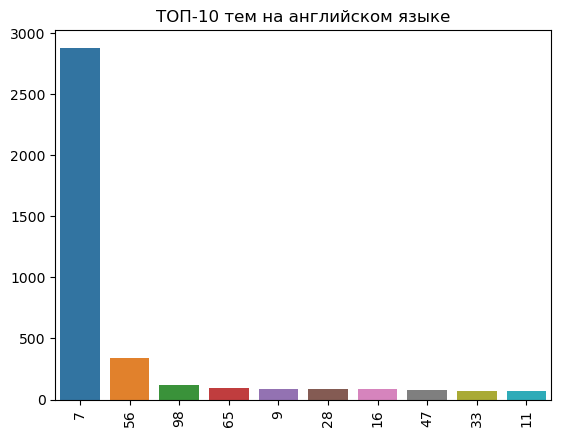

In [44]:
top10topic_en = df_posts_en['topic'].value_counts().head(10)
sns.barplot(x=top10topic_en.index, y=top10topic_en.values, order=top10topic_en.index).set_title('ТОП-10 тем на английском языке')
plt.xticks(rotation=90)
plt.show()

# Формулирование топ-10 тем постов

Номера тем не дают нам никакой информации. Сформулируем их по-человечески. А для этого посмотрим ключевые слова и типичные тексты

## Ключевые слова и типичные статьи для топ-10 тем

Предварительно создадим списки с номерами тем для последующего создания словарей

In [45]:
top10list_ru = top10topic_ru.index
top10list_en = top10topic_en.index

Взглянем на ключевые слова по каждой теме. Для этого напишем функцию

In [46]:
def topic_text(id2word, lda, topics, posts, top10list=top10list_ru):
    for topic in top10list:
        c = lda.components_[topic, :]
        topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
        doc_id = np.argmax(topics[:, topic])
        print("Тема",topic, ":")
        print(", ".join(topic_tokens))
        print("***************************")
        print("Текст на тему",topic, ":")
        print(posts.loc[doc_id]['post'])
        print("\n ")

### Русский язык

In [47]:
topic_text(id2word_ru, lda_ru, topics_ru, df_posts_ru)

Тема 56 :
возможность, работать, команда, которые, новый, ваш, жизнь, первый, проект, время, год, весь, хороший, компания, человек, мочь, работа, наш, свой, это
***************************
Текст на тему 56 :
Новые инструменты на базе AI1. Courseau — делайте курсы из чего угодно. Возьмите что-нибудь сложное: видео на YouTube, научную статью или подкаст и превратите это в увлекательный мини-курс. (https://courseau.co/)2. Playtext — превратите любой текст в аудиокнигу и читай в 2 раза быстрее (https://playtext.app/)3. 60sec — сайт с помощью AI за 60 секунд. (https://60sec.site/)4. Simulai — сгенерируйте свой блог с готовыми статьями. (https://www.simulai.co/)5. Ecoute — транскрипция видео (вебинаров) и подсказки. (https://lnkd.in/edzAKaSp)6. TLDV — расширение для Zoom для выделения важных моментов на созвонах. (https://tldv.io/)7. ChatNode — обучайте ChatGPT на ваших собственных данных. (https://https://www.linkedin.com/redir/general-malware-page?url=www%2echatnode%2eai%2F%298. Hushl —улу

По одному тексту и ключевым словам довольно непросто сформулировать общую тему конкретной категории постов, поэтому по каждой теме лучше прочитать несколько текстов и выбрать превалирующий контекст.

Для того, чтобы не загромождать ноутбук множеством текстов приведу пример кода, который использовался для "углубленного чтения" (таким образом обрабатывались тексты на обоих языках)

In [48]:
list(df_posts_ru.query('topic == 24')['post'].sample(20))

['Всем привет!\r\nКоманда Webtronics опубликовала статью про лучшие SEO сервисы, которыми сама пользуется:\r\n\r\nhttps://lnkd.in/dDaKRs4z',
 '⚠️⚠️⚠️ 52 дизайн системы для вашей работы!Продолжая тему дизайн систем принес вам отличный ресурс, где собраны 52 дизайн системы крупных компаний всех направлений.А самое приятное, что там есть ссылки на Figma файлы с дизайн система, которые можно посмотреть и забрать себе понравившиеся элементы, а главное вдохновится⚡️ Скорее переходите на ресурс - https://lnkd.in/djmDUDDE ,анализируйте дизайн системы и создавай собственные!👾 Мой телеграмм канал -\xa0https://lnkd.in/dF6vEVJXТам куча полезногоВ канале:\xa0- Design Help, файл 40+ материалов для повышения ваших скиллов- Розыгрыш консультаций по карьерному треку и разбору портфолио\xa0- Прямые эфиры с дизайном\xa0- Полезные статьи #design\xa0#linkedin\xa0#instagram\xa0#help\xa0#design\xa0#webdesign\xa0#webdevelopment\xa0#graphicdesign\xa0#UIUX #digitaldesign\xa0#responsivewebdesign\xa0#HTML\xa0#CSS

По итогам анализа ключевых слов и текстов ясформулировал следующие темы постов на русском языке:
- развитие/тренды (инструменты, обучение)
- поддержка/коллаборация (различные мысли)
- выход на работу
- поиск работы
- поиск сотрудников
- события (саммиты, конференции, вебинары)
- предложения услуг бизнесу
- новый навык (получен значок на Linkedin)
- анонсы/стартапы
- сайты/статьи/чаты

Сохраним их в словарь:

In [49]:
top10_ru = ['развитие/тренды',
            'поддержка/коллаборация',
            'выход на работу',
            'поиск работы',
            'поиск сотрудников',
            'события',
            'предложения бизнес-услуг',
            'новый навык',
            'анонсы/стартапы',
            'сайты/статьи/чаты']

topics_ru_dict = dict(zip(top10list_ru, top10_ru))

topics_ru_dict

{56: 'развитие/тренды',
 39: 'поддержка/коллаборация',
 25: 'выход на работу',
 49: 'поиск работы',
 34: 'поиск сотрудников',
 94: 'события',
 4: 'предложения бизнес-услуг',
 17: 'новый навык',
 1: 'анонсы/стартапы',
 24: 'сайты/статьи/чаты'}

### Английский язык

In [50]:
topic_text(id2word_en, lda_en, topics_en, df_posts_en, top10list_en)

Тема 7 :
ai, make, use, get, like, experience, need, new, company, one, data, product, help, time, project, work, team, business, software, development
***************************
Текст на тему 7 :
Hi there 👋 How is Bitrix24 better than 99% of other solutions on the market?✔ replaces all your current SaaS solutions;✔ free forever for unlimited users;✔ easy to migrate data from other systems;✔ integrated with all your favorite services and applications;✔ used, liked and trusted by 12,000,000+ users worldwide;✔ 100% fixed fee: predictable costs, no pricing per user.Instead of dozens of services and apps, start using a single platform to organise your entire company.#itachsoft #bitrix24 #automatization #business #crm #it #sales #software

 
Тема 56 :
commerce, people, possible, bring, part, technologies, digital, professionals, ideas, new, insights, goals, potential, community, skills, us, world, future, together, also
***************************
Текст на тему 56 :
Strolling down Wall Str

Аналогично работе с русским языком, просмотрел больше текстов по каждой популярной теме и сформулировал их так:
- развитие/тренды
- поддержка/коллаборация
- события
- сайты/статьи/чаты
- поиск работы
- выход на работу
- анонсы/стартапы
- новый навык
- AI/ML
- поиск сотрудников

Практически все темы присутствуют и в русскоязычном сегменте, однако популярность их отличается. Сформируем словарь:

In [51]:
top10_en = ['развитие/тренды',
            'поддержка/коллаборация',
            'события',
            'сайты/статьи/чаты',
            'поиск работы',
            'выход на работу',
            'анонсы/стартапы',
            'новый навык',
            'AI/ML',
            'поиск сотрудников']

topics_en_dict = dict(zip(top10list_en, top10_en))
topics_en_dict

{7: 'развитие/тренды',
 56: 'поддержка/коллаборация',
 98: 'события',
 65: 'сайты/статьи/чаты',
 9: 'поиск работы',
 28: 'выход на работу',
 16: 'анонсы/стартапы',
 47: 'новый навык',
 33: 'AI/ML',
 11: 'поиск сотрудников'}

Выполним более интерпретируемый анализ по популярным темам

# Анализ по темам

Сформируем датафреймы, которые содержат посты популярных тем

In [52]:
df_top10_ru = df_posts_ru.copy()
df_top10_ru = df_top10_ru.query('topic in @top10list_ru')

df_top10_en = df_posts_en.copy()
df_top10_en = df_top10_en.query('topic in @top10list_en')

display(df_top10_ru.sample(5))
df_top10_en.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
1537,https://www.linkedin.com/in/yugoru/recent-acti...,0,Недавно на одном круглом столе обсуждали как а...,10,1.0,0.0,ru,458,56
568,https://www.linkedin.com/in/aleksandr-potapov/...,0,Разработка внутрикорпоративного VPN-порталаНаш...,1,0.0,0.0,ru,1210,56
1873,https://www.linkedin.com/in/ulugbekalimov/rece...,0,Запуск программы “Soft-Landing in Uzbekistan f...,1,0.0,0.0,ru,1008,94
2100,https://www.linkedin.com/in/elminaliev/recent-...,0,Понедельничный дайджест tech and business news...,13,4.0,0.0,ru,1781,39
159,https://www.linkedin.com/in/olgaperun/recent-a...,0,"Друзья, Новость дня!Давно шла к этому и вот сн...",0,0.0,0.0,ru,878,56


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic
1252,https://www.linkedin.com/in/abdelhai95/recent-...,0,"I will share my notes on #JS, If I missed some...",1,0.0,0.0,en,1220,7
5774,https://www.linkedin.com/in/alexander-lobtsov,0,"Dear friends, colleagues, classmates, acquaint...",19,0.0,4.0,en,1670,7
4278,https://www.linkedin.com/in/kandiralana/recent...,0,"This is the city of Dnipro. Saturday, weekend ...",108,2.0,27.0,en,644,7
5338,https://www.linkedin.com/in/andrrey/recent-act...,0,We’re thrilled to share that we've achieved th...,1,0.0,0.0,en,238,7
1934,https://www.linkedin.com/in/viktoriia-bilyk-38...,0,"Guys, tell me, what are your plans for Februar...",1,0.0,0.0,en,530,7


Заменим номера тем их сформулированными ранее текстами

In [53]:
def rutopic_num_to_text(num):
    try:
        return topics_ru_dict[num]
    except:
        return num

df_top10_ru['topic_text'] = df_top10_ru['topic'].apply(rutopic_num_to_text)
df_top10_ru.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic,topic_text
2253,https://www.linkedin.com/in/tatiana-klevanets-...,https://www.linkedin.com/feed/update/urn:li:ac...,"Друзья, в крупный онлайн-гипермаркет детских т...",3,0.0,0.0,ru,557,56,развитие/тренды
724,https://www.linkedin.com/in/thearsen/recent-ac...,0,Привет! Я тут наконец-то прошел часовой тест н...,6,4.0,0.0,ru,466,39,поддержка/коллаборация
2142,https://www.linkedin.com/in/anya-pavlova-a0b45...,0,Всем привет!27–28 мая мы проведём Weekend Offe...,9,0.0,1.0,ru,616,94,события
917,https://www.linkedin.com/in/argunov/recent-act...,0,"Переезжаем с bankingplace.ru, идем в новые инд...",4,1.0,1.0,ru,2946,56,развитие/тренды
2389,https://www.linkedin.com/in/metavxnn,0,"С удовольствием сообщаю, что я начинаю работу ...",1.0,0.0,0.0,ru,121,25,выход на работу


In [54]:
def entopic_num_to_text(num):
    try:
        return topics_en_dict[num]
    except:
        return num

df_top10_en['topic_text'] = df_top10_en['topic'].apply(entopic_num_to_text)
df_top10_en.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic,topic_text
1420,https://www.linkedin.com/in/dmitry-creator/rec...,0,One day a man asked me: What does it take to b...,38,2.0,0.0,en,1047,7,развитие/тренды
2211,https://www.linkedin.com/in/tetiana-holovchenk...,0,It’s a Friday. We’ve stood for more than a wee...,2,0.0,0.0,en,829,56,поддержка/коллаборация
5122,https://www.linkedin.com/in/supersymmetry/rece...,0,We're excited to announce we're up for site of...,1,0.0,0.0,en,213,56,поддержка/коллаборация
3132,https://www.linkedin.com/in/katerinafilinkova/...,0,“This technology is going to reshape pretty mu...,7,0.0,3.0,en,514,7,развитие/тренды
5017,https://www.linkedin.com/in/george--adam/recen...,0,Our team is engaged in outsourcing development...,18,0.0,6.0,en,1622,7,развитие/тренды


Готово. Сформируем общий датасет по двум языкам и решим вопрос со столбцом `comments_cnt`, в котором присутствуют разнородные данные. Придётся заменить запятые и пробелы на точки, чтобы в итоге привести столбец к типу `float`

In [55]:
df_top10 = pd.concat([df_top10_en, df_top10_ru]).reset_index(drop=True)

In [56]:
def reactions_type(x):
    x = str(x)
    if x.__contains__(',') == True:
        x = x.replace(',', '.')
        return x
    elif x.__contains__(' ') == True:
        x = x.replace(' ', '.')
        return x
    return x

df_top10['reactions_cnt'] = df_top10['reactions_cnt'].apply(reactions_type).astype('float')

## Сводные таблицы

Построим сводную таблицу, показывающую информацию по каждой теме в разрезе по языкам: средние и медианные значения количества реакций, комментариев, репостов, а также среднее и медианное значение длины поста.

Также будут и максимальные значения

In [57]:
pd.pivot_table(df_top10, index=['topic_text', 'language'], values=['reactions_cnt', 'comments_cnt', 'reposts_cnt', 'post_len'], aggfunc=['mean', 'median', 'max'])

mean                             \
                                  comments_cnt     post_len reactions_cnt   
topic_text               language                                           
AI/ML                    en          18.361111   325.111111     30.686514   
анонсы/стартапы          en          10.867470   372.060241     24.575422   
                         ru          13.151515   607.454545     53.842152   
выход на работу          en          11.552941   168.705882     21.074553   
                         ru           8.485714   140.414286     24.719400   
новый навык              en           1.933333   204.466667     24.866667   
                         ru           0.484848   143.727273     20.666667   
поддержка/коллаборация   en           8.514881   576.288690     24.987949   
                         ru           4.844488   886.620079     18.984252   
поиск работы             en           1.617978   202.741573     20.134831   
                         ru           0.833333   243.030303     12.742424   
поиск сотрудников        en           0.147059   457.235294      3.323529   
                         ru           1.369231   838.046154     16.815385   
предложения бизнес-услуг ru           0.166667   207.638889      3.861111   
развитие/тренды          en          11.938542   843.444097     20.900023   
                         ru           5.601361  1169.337415     27.057824   
сайты/статьи/чаты        en          17.065934   484.637363     20.033132   
                         ru           0.571429   624.357143     20.928571   
события                  en           1.106557   236.647541      9.472008   
                         ru           1.377049   604.983607     10.475410   

                                                    median           \
                                  reposts_cnt comments_cnt post_len   
topic_text               language                                     
AI/ML                    en         23.944444          0.0    229.5   
анонсы/стартапы          en          1.144578          0.0    288.0   
                         ru         20.939394          0.0    416.0   
выход на работу          en          0.376471          0.0     89.0   
                         ru          0.142857          1.0    109.5   
новый навык              en          1.186667          0.0    159.0   
                         ru          0.727273          0.0    140.0   
поддержка/коллаборация   en         12.395833          0.0    443.5   
                         ru          1.381890          0.0    663.0   
поиск работы             en          2.898876          1.0    170.0   
                         ru          2.121212          0.0    208.0   
поиск сотрудников        en          0.411765          0.0     71.0   
                         ru          1.507692          0.0    675.0   
предложения бизнес-услуг ru          0.111111          0.0    148.5   
развитие/тренды          en         12.031944          0.0    677.0   
                         ru          6.238095          0.0    987.0   
сайты/статьи/чаты        en          9.659341          0.0    311.0   
                         ru          1.928571          0.0    537.0   
события                  en          1.631148          0.0    176.5   
                         ru          0.590164          0.0    520.0   

                                                                     max  \
                                  reactions_cnt reposts_cnt comments_cnt   
topic_text               language                                          
AI/ML                    en                 5.0         0.0        635.0   
анонсы/стартапы          en                 6.0         0.0        764.0   
                         ru                 3.0         0.0        143.0   
выход на работу          en                 8.0         0.0        705.0   
                         ru                10.5         0.0        427.0   
новый навык              en 

**Выводы**: 
- в глаза бросается, что медианные значения количества реакций сильно отличаются от средних, значит есть редкие посты с аномально большим количеством реакций (что и показывает раздел с максимальными количествами). 
- Медианные значения репостов и комментариев практически везде нулевые - это не самые популярные действия у нашей аудитории. Больший акцент на реакциях.
- Максимум реакций у русскоязычных постов о выходе на работу (медиана 10.5), минимум у русскоязычных постов о новом навыке (медиана 1.0). Эта же тема на английском языке приветствуется очень активно (медиана  9.0).
- Самые длинные посты в теме "развитие/тренды" на русском языке (медиана 987), самые короткие - "поиск сотрудников" на английском (медиана 71)

Выведем ту же информацию, но без раскладки по темам

In [58]:
pd.pivot_table(df_top10, index=['language'], values=['reactions_cnt', 'comments_cnt', 'reposts_cnt', 'post_len'], aggfunc=['mean', 'median', 'max'])

mean                                             median  \
         comments_cnt    post_len reactions_cnt reposts_cnt comments_cnt   
language                                                                   
en          10.878493  725.153807     20.889552   10.797488          0.0   
ru           4.814679  903.277064     22.641376    3.880122          0.0   

                                                     max           \
         post_len reactions_cnt reposts_cnt comments_cnt post_len   
language                                                            
en            532           6.0         0.0        967.0     2983   
ru            684           5.0         0.0        449.0     2994   

                                    
         reactions_cnt reposts_cnt  
language                            
en               995.0       979.0  
ru               921.0       562.0

**Выводы**:
- в постах топ-10 тем на английском и русском языках примерный паритет по действиям пользователей.
- англоязычные посты чуть короче и чуть чаще отмечаются реакциями. Комментировать и репостить особо не желают пользователи обоих языков

Посчитаем количество текстов по темам и языкам

In [59]:
pd.pivot_table(df_top10, index=['topic_text', 'language'], values='topic', aggfunc=['count']).transpose()

topic_text  AI/ML анонсы/стартапы     выход на работу     новый навык      \
language       en              en  ru              en  ru          en  ru   
count topic    72              83  33              85  70          75  33   

topic_text  поддержка/коллаборация      поиск работы     поиск сотрудников  \
language                        en   ru           en  ru                en   
count topic                    336  508           89  66                68   

topic_text      предложения бизнес-услуг развитие/тренды       \
language     ru                       ru              en   ru   
count topic  65                       36            2880  735   

topic_text  сайты/статьи/чаты     события      
language                   en  ru      en  ru  
count topic                91  28     122  61

Для большей наглядности представим в виде графика

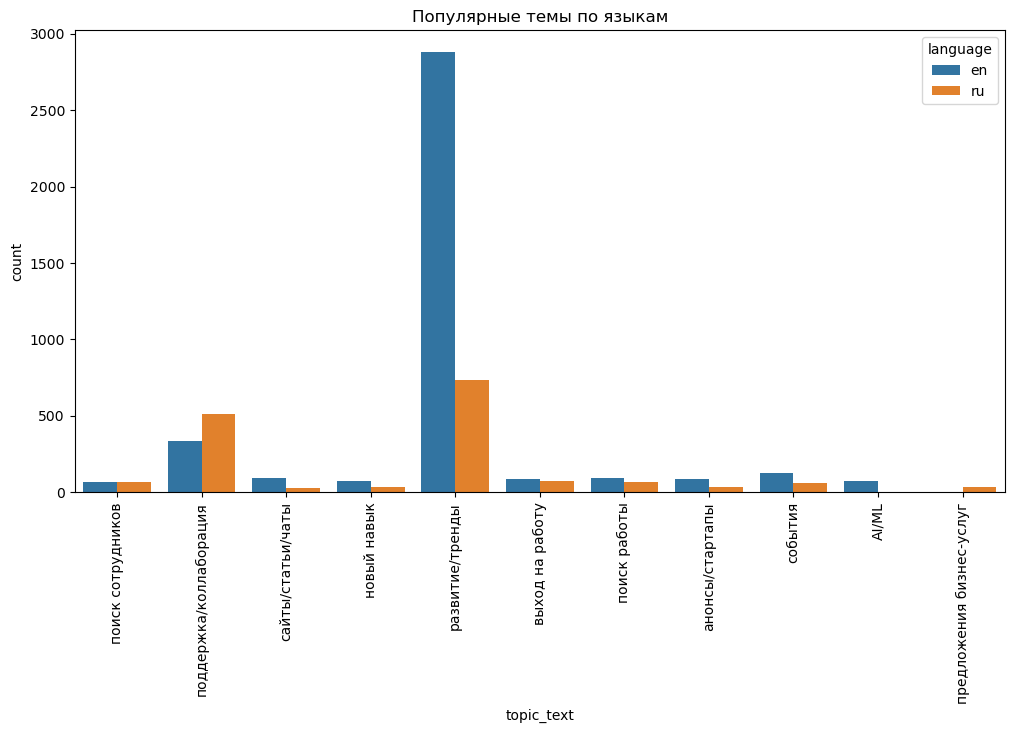

In [60]:
plt.figure(figsize=(12, 6))
sns.countplot(df_top10, x=df_top10['topic_text'], hue='language').set_title('Популярные темы по языкам')
plt.xticks(rotation=90)
plt.show()

**Выводы**:
- англоязычных постов сильно больше - везде кроме темы "поддержка/коллаборация" количество русскоязычных постов меньше. На русском языке сильно чаще пишут на эту тему.
- сильнее выражено "лидерство" темы "развитие/тренды" у "англичан"
- уникальная русскоязычная тема "предложения бизнес-услуг"
- уникальная англоязычная тема "AI/ML"

## Самые популярные посты по темам

Поищем посты, лидирующие по количеству репостов, комментариев и реакций в разрезе тем и языков. Для этого построим сводную таблицу с применением функции `idxmax`, а затем "вытащим" соответствующий индексу пост

In [61]:
def get_post(idx):
    return df_top10.loc[idx]['post']

popular_posts = pd.pivot_table(df_top10, index=['topic_text', 'language'], values=['reactions_cnt', 'comments_cnt', 'reposts_cnt'], aggfunc='idxmax')
popular_posts['comments_cnt'] = popular_posts['comments_cnt'].apply(get_post)
popular_posts['reactions_cnt'] = popular_posts['reactions_cnt'].apply(get_post)
popular_posts['reposts_cnt'] = popular_posts['reposts_cnt'].apply(get_post)

popular_posts

comments_cnt  \
topic_text               language                                                      
AI/ML                    en        Even Walt Disney will tell you that designing ...   
анонсы/стартапы          en        10 visuals that will make your life and mindse...   
                         ru        Очень прошу репост!!!Дано: тестировщица с редк...   
выход на работу          en        Happy #NationalBestFriendsDay! We’re celebrati...   
                         ru        Привет линкедин, я к вам за помощью. 🙏 Мы были...   
новый навык              en        BBC interviewer: "Thank you Mr. President, tha...   
                         ru                               Еще один кот тестировщика)   
поддержка/коллаборация   en        Cyber Security Lifetime Membership Pass - http...   
                         ru        Стоит ли продолжать общение с компанией котора...   
поиск работы             en        Hi everyone - I am looking for a new role and ...   
                         ru        Здравствуйте, я в поиске новой карьерной возмо...   
поиск сотрудников        en        I’m #hiring. Know anyone who might be interested?   
                         ru        В поисках QA тестировщика в интернет-магазин. ...   
предложения бизнес-услуг ru        Штош, надоело мне в IT. Уволюсь и открою пивну...   
развитие/тренды          en        One thing ChatGPT can’t do is visualise data, ...   
                         ru        Коллеги, прошу репост.Одной из целей 2020 (все...   
сайты/статьи/чаты        en        Check out these 16 Figma plugins saving time f...   
                         ru        👀 Последний проект нашей студии получил наград...   
события                  en        Happy Birthday, Mr. President. A leader, a Ukr...   
                         ru        Аналитика, которую мы заслужили 😁 Лайфхак для ...   

                                                                       reactions_cnt  \
topic_text               language                                                      
AI/ML                    en        Photoshop will be forever changed after this. ...   
анонсы/стартапы          en        Indian young unbeatable chess titan Gukesh Dom...   
                         ru        Очень прошу репост!!!Дано: тестировщица с редк...   
выход на работу          en        I’m happy to share that I’m starting a new pos...   
                         ru        Сегодня знаменательный для меня день. Я начина...   
новый навык              en        BBC interviewer: "Thank you Mr. President, tha...   
                         ru                               Еще один кот тестировщика)   
поддержка/коллаборация   en        Free Courses + Certificates from GitLabGitLab ...   
                         ru        🔥 Если вы в поисках удаленной работы или допол...   
поиск работы             en        Hi everyone - I am looking for a new role and ...   
                         ru        Привет LinkedIn! Я в поиске новой карьерной во...   
поиск сотрудников        en        I'm #hiring professionals. Do you know people ...   
                         ru        В поисках QA тестировщика в интернет-магазин. ...   
предложения бизнес-услуг ru        Правила типографики для дизайнеров#typography ...   
развитие/тренды          en        React JS  🌟🌟🌟One of the famous and widely use ...   
                         ru        С трепетом готов представить свой продукт. Реф...   
сайты/статьи/чаты        en        Finally finished! IoT gate for special sensors...   
                         ru        ⚠️⚠️⚠️ 52 дизайн системы для вашей работы!Прод...   
события                  en        How are European tech companies defying the he...   
                         ru        Аналитика, которую мы заслужили 😁 Лайфхак для ...   

                                                                         reposts_cnt  
topic_text               language                                                     
AI/ML                   

Отличная вышла таблица для анализа it-рекрутером)) а мы пока сформируем суммарные реакции (комментарии + реакции + репосты), чтобы оценить охват/вовлеченность аудитории по языкам/темам

In [62]:
df_top10['sum_reactions'] = df_top10['comments_cnt'] + df_top10['reactions_cnt'] + df_top10['reposts_cnt']
top_10_posts_sum = pd.pivot_table(df_top10, index=['topic_text', 'language'], values=['sum_reactions'], aggfunc=['mean', 'median']).transpose()
top_10_posts_sum

topic_text                AI/ML анонсы/стартапы            выход на работу  \
language                     en              en         ru              en   
mean   sum_reactions  72.992069        36.58747  87.933061       33.003965   
median sum_reactions   6.000000         7.00000   7.000000       11.000000   

topic_text                      новый навык            поддержка/коллаборация  \
language                     ru          en         ru                     en   
mean   sum_reactions  33.347971   27.986667  21.878788              45.898664   
median sum_reactions  12.500000   11.000000   1.000000               8.000000   

topic_text                     поиск работы           поиск сотрудников  \
language                    ru           en        ru                en   
mean   sum_reactions  25.21063    24.651685  15.69697          3.882353   
median sum_reactions   7.50000    11.000000   6.00000          2.000000   

topic_text                      предложения бизнес-услуг развитие/тренды  \
language                     ru                       ru              en   
mean   sum_reactions  19.692308                 4.138889       44.870509   
median sum_reactions   6.000000                 1.500000        7.000000   

topic_text                     сайты/статьи/чаты               события  \
language                    ru                en         ru         en   
mean   sum_reactions  38.89728         46.758407  23.428571  12.209713   
median sum_reactions   9.00000          7.000000  10.000000   6.000000   

topic_text                       
language                     ru  
mean   sum_reactions  12.442623  
median sum_reactions   3.000000

**Выводы:**
- большая медианная разница в реакциях на новый навык. Русскоязычным практически безразличен этот момент. Англоязычные посты имеют по этой теме огромное преимущество по реакциям (в 11 раз больше по медиане)
- приличная медианная разница в реакциях на тему "поиск сотрудников" - русскоязычные реагируют в 3 раза чаще.
- "англичане" в два раза чаще реагируют на события.
- максимум реакций по теме "выход на работу" по обоим языкам (ан - 11, ру - 12.5). Соцсеть профессиональных контактов всё-таки.
- предложения бизнес-услуг вызывают также минимум реакций (1,5)

## Определение ТОП-тем в менторстве

Выберем из всех имеющихся постов те, в которых есть хотя бы один тег из списка, предоставленного it-рекрутером. Для этого создадим "технические" столбцы с картой наличия тега в конкретном столбце и посмотрим, сколько постов попало в выборку.

In [63]:
df_posts = pd.concat([df_posts_ru, df_posts_en])
tag_list = ['mentoringIT', 'softskills', 'наставник', 'наставничество', 'ментор', 'менторство', 'mentor', 'mentorship', 'коуч', 'коучинг', 'coach', 'coaching', 'experience', 'опыт', 'бадди', 'buddy']

for tag in tag_list:
    df_posts[tag] = df_posts['post'].apply(lambda x: 1 if x.__contains__('#'+tag) == True else 0)
    
df_posts[tag_list].sum()

mentoringIT        0
softskills         8
наставник          0
наставничество     0
ментор             6
менторство         0
mentor            18
mentorship         6
коуч               2
коучинг            1
coach              6
coaching           5
experience        89
опыт               3
бадди              0
buddy              0
dtype: int64

Более 100 постов имеется. Отберем посты, учитывая, что каждый из них может содержать более одного тега и проверим результат визуально, не забыв удалить "технические" столбцы.

In [64]:
df_posts['sum_tag'] = 0

for tag in tag_list:
    df_posts['sum_tag'] += df_posts[tag]
    
mentorship = df_posts.query('sum_tag != 0') #.reset_index(drop=True)
#mentorship.to_excel('mentorship.xls')
mentorship = mentorship.reset_index(drop=True)
mentorship = mentorship.drop(tag_list, axis=1)
mentorship.head()

C:\Users\Валерий Валов\AppData\Local\Temp\ipykernel_15716\3609969588.py:7: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  mentorship.to_excel('mentorship.xls')


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len,topic,sum_tag
0,https://www.linkedin.com/in/mikhailsolovyev/re...,0,"Прочитал на Хабр отличный материал о том, как ...",13,1.0,0.0,ru,408,56,1
1,https://www.linkedin.com/in/%D0%BF%D0%BE%D0%BB...,0,🔵 Самая большая подборка для прокачки soft ski...,"1,569",85.0,361.0,ru,890,23,1
2,https://www.linkedin.com/in/ordalion/recent-ac...,0,Делал тестовое для Тинькофф. В кейсе расписал ...,30,0.0,0.0,ru,181,76,1
3,https://www.linkedin.com/in/enjirouz/recent-ac...,0,"Как просить то, что хочешь и добиваться желаем...",4,0.0,0.0,ru,153,90,1
4,https://www.linkedin.com/in/anna-zaytseva-hrst...,0,Вы в поисках работы?#карьера Компании и сотруд...,31,0.0,0.0,ru,1146,39,1


Прекрасно. Приведем в соответствие номера тем к текстовой формулировке темы из словарей топ-10 популярных тем. Для этого разделим выборку по языку, применим ранее написанные функции, соединим всё обратно и сформируем топ.

In [65]:
mentorship_ru = mentorship.query('language == "ru"').copy()
mentorship_en = mentorship.query('language == "en"').copy()

mentorship_ru['topic_text'] = mentorship_ru['topic'].apply(rutopic_num_to_text)
mentorship_en['topic_text'] = mentorship_en['topic'].apply(entopic_num_to_text)

mentorship = pd.concat([mentorship_ru, mentorship_en])

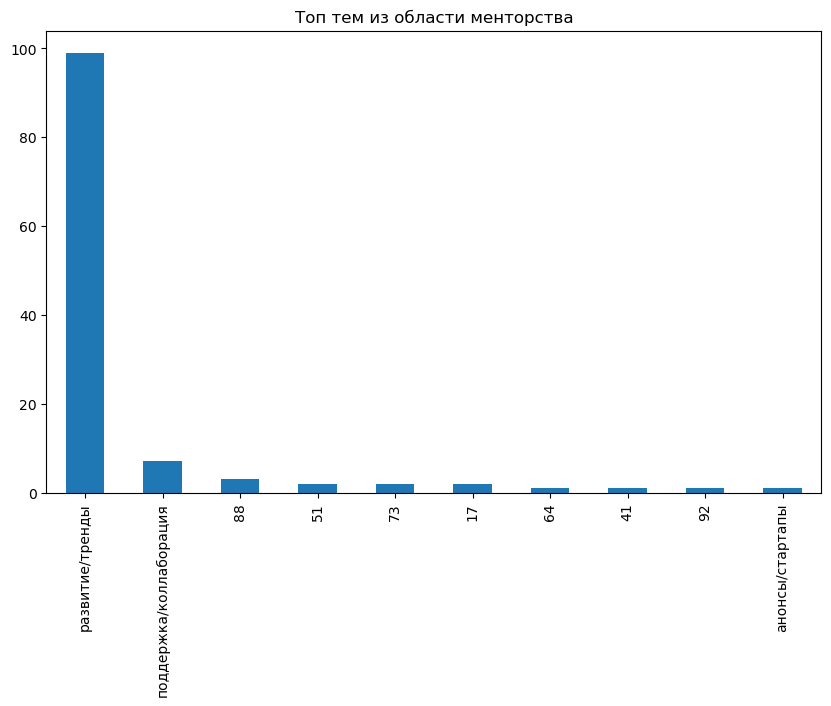

In [66]:
mentorship['topic_text'].value_counts().head(10).plot(kind='bar', figsize=(10, 6))

plt.title('Топ тем из области менторства')
plt.show()

Как видно, внимания заслуживают лишь 6 тем, и то с натяжкой. Для 106 постов определены темы, на их и стоит ориентироваться при составлении контент-плана: "Развитие/тренды" и "Поддержка/коллаборация" (примерно 82% постов на эти темы). 
В свете этого решено было проанализировать вручную темы постов по теме менторство и вот, что вышло:

In [68]:
mentoring_topics = pd.read_excel('analisys_data/topics.xlsx')
mentoring_topics = sum(mentoring_topics.values.tolist(), [])

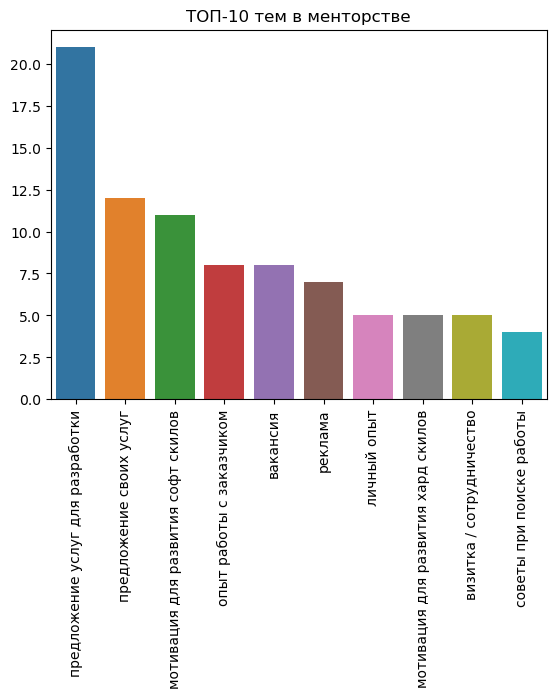

In [69]:
top10_mentoring_topics = pd.Series(mentoring_topics).value_counts().head(10)

sns.barplot(x=top10_mentoring_topics.index, y=top10_mentoring_topics.values, order=top10_mentoring_topics.index).set_title('ТОП-10 тем в менторстве')
plt.xticks(rotation=90)
plt.show()

А как обстоят дела с реакцией аудитории "менторства" в разрезе языка поста?

In [70]:
mentorship['reactions_cnt'] = mentorship['reactions_cnt'].apply(reactions_type).astype('float')
pd.pivot_table(mentorship, index=['language'], values=['reactions_cnt', 'comments_cnt', 'reposts_cnt', 'post_len'], aggfunc=['count', 'mean', 'median', 'max'])

count                                            mean  \
         comments_cnt post_len reactions_cnt reposts_cnt comments_cnt   
language                                                                
en                107      107           107         107     6.018692   
ru                 22       22            22          22    12.318182   

                                                      median           \
             post_len reactions_cnt reposts_cnt comments_cnt post_len   
language                                                                
en        1025.504673      7.887009    5.056075          0.0    848.0   
ru        1221.045455     37.662227   18.727273          0.0   1102.5   

                                            max                         \
         reactions_cnt reposts_cnt comments_cnt post_len reactions_cnt   
language                                                                 
en                 4.0         0.0        265.0     2895          74.0   
ru                11.0         0.0         93.0     2963         226.0   

                      
         reposts_cnt  
language              
en             260.0  
ru             361.0

**Выводы:**
- в данной области доля англоязычных постов ещё больше, чем в общей выборке - более 80%
- чаще реагирует русскоязычная аудитория (11 против 4 по медиане)

сделаем разрез по темам

In [71]:
mentorship['sum_reactions'] = mentorship['comments_cnt'] + mentorship['reactions_cnt'] + mentorship['reposts_cnt']
mentorship_posts_sum = pd.pivot_table(mentorship, index=['topic_text', 'language'], values=['sum_reactions'], aggfunc=['mean', 'median']).transpose()
mentorship_posts_sum

topic_text             17       23   36   39   41       48   51   60    64  \
language               en       ru   en   en   en       en   en   ru    en   
mean   sum_reactions  0.5  447.569  1.0  0.0  0.0  275.165  1.5  4.0  19.0   
median sum_reactions  0.5  447.569  1.0  0.0  0.0  275.165  1.5  4.0  19.0   

topic_text             73  ...   85    88        90    92 анонсы/стартапы  \
language               en  ...   ru    en   ru   ru    en              en   
mean   sum_reactions  1.5  ...  9.0  12.0  2.0  4.0  37.0            35.0   
median sum_reactions  1.5  ...  9.0  12.0  2.0  4.0  37.0            35.0   

topic_text           поддержка/коллаборация        развитие/тренды        
language                                 en     ru              en    ru  
mean   sum_reactions               4.333333  75.25       17.732701  59.5  
median sum_reactions               2.000000  72.00        5.000000  14.5  

[2 rows x 23 columns]

проанализируем только популярные темы от топик-моделинга: "поддержка/коллаборация" и "развитие/тренды"

**Выводы:**
- медианное значение суммарного количества репостов, реакций и комментариев у русскоязычных постов сильно больше (в 36 раз и в 3 раза). Думаю, это связано с малым количеством постов на русском языке, поэтому данные скорее всего некорректны и четких выводов по ним делать нельзя.

# Общий вывод

В ходе выполнения проекта были напарсены данные с сайта LinkedIn, на основе которых после лемматизации, токенизации и векторизации текстов, алгоритмом LDA был произведен TopicModeling.

Далее произведен анализ, на основе которого сделаны следующие выводы:

**Популярные темы у англоязычной и русскоязычной аудиторий:**
- развитие/тренды
- поддержка/коллаборация
- события
- сайты/статьи/чаты
- поиск работы
- выход на работу
- анонсы/стартапы
- новый навык
- AI/ML
- поиск сотрудников
- предложения бизнес/услуг

9 общих тем у двух аудиторий

**В разрезе по темам и языкам топ-10 популярных у ЦА тем:**
- медианные значения количества реакций сильно отличаются от средних, значит есть редкие посты с аномально большим количеством реакций 
- медианные значения репостов и комментариев практически везде нулевые - это не самые популярные действия у нашей аудитории. Больший акцент на реакциях.
- максимум реакций у русскоязычных постов о выходе на работу (медиана 10.5), минимум у русскоязычных постов о новом навыке (медиана 1.0). Эта же тема на английском языке приветствуется очень активно (медиана  9.0).
- самые длинные посты в теме "развитие/тренды" на русском языке (медиана 987), самые короткие - "поиск сотрудников" на английском (медиана 71)

**Количество постов по темам и языкам:**
- англоязычных постов сильно больше - везде кроме темы "поддержка/коллаборация" количество русскоязычных постов меньше. На русском языке сильно чаще пишут на эту тему.
- сильнее выражено "лидерство" темы "развитие/тренды" у "англичан"
- уникальная русскоязычная тема "предложения бизнес-услуг"
- уникальная англоязычная тема "AI/ML"

**Суммарные действия по языкам ЦА и темам (посты+репосты+реакции):**
- большая медианная разница в реакциях на новый навык. Русскоязычным практически безразличен этот момент. Англоязычные посты имеют по этой теме огромное преимущество по реакциям (в 11 раз больше по медиане)
- приличная медианная разница в реакциях на тему "поиск сотрудников" - русскоязычные реагируют в 3 раза чаще.
- "англичане" в два раза чаще реагируют на события.
- максимум реакций по теме "выход на работу" по обоим языкам (ан - 11, ру - 12.5). Соцсеть профессиональных контактов всё-таки.
- предложения бизнес-услуг вызывают также минимум реакций (1,5)

Далее по тегам 'mentoringIT', 'softskills', 'наставник', 'наставничество', 'ментор', 'менторство', 'mentor', 'mentorship', 'коуч', 'коучинг', 'coach', 'coaching', 'experience', 'опыт', 'бадди', 'buddy' были выбраны **посты, относящиеся к наставничеству**. Их оказалось в нашей выборке 129 штук. 

На основе тем после топик-моделинга какое-то адекватное разделение сделать не удалось (99 из 129 - тема "развитие/тренды"), поэтому тексты этих постов были проанализированы it-рекрутером вручную, и выделены топ-10 популярных тем из этой области (в порядке убывания популярности):
- предложение услуг для разработки
- предложение своих услуг
- мотивация для развития софт скилов
- опыт работы с заказчиком
- вакансия
- реклама
- личный опыт
- мотивация для развития хард скилов
- визитка / сотрудничество
- советы при поиске работы

А на основе анализа реакций были сделаны следующие выводы:

**В разрезе по языкам в постах о менторстве:**
- в данной области доля англоязычных постов ещё больше, чем в общей выборке - более 80%
- чаще реагирует русскоязычная аудитория (11 против 4 по медиане)